In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [2]:
def my_imfilter(s, filter, pad_type='zero'):
    """
    s: Input image (numpy array)
    filter: 2D filter (numpy array)
    pad_type: Type of padding - 'zero', 'replicate', or 'reflect'
    """
    # Get dimensions
    m, n = filter.shape
    h, w = s.shape
    
    # Define padding size
    pad_size = (m // 2, n // 2)
    
    # Apply padding based on pad_type
    if pad_type == 'zero':
        padded_image = np.pad(s, pad_size, mode='constant', constant_values=0)
    elif pad_type == 'replicate':
        padded_image = np.pad(s, pad_size, mode='edge')
    elif pad_type == 'reflect':
        padded_image = np.pad(s, pad_size, mode='reflect')
    else:
        raise ValueError("Invalid padding type")
    
    # Initialize the output image
    filtered_image = np.zeros_like(s)
    
    # Perform convolution
    for i in range(h):
        for j in range(w):
            region = padded_image[i:i+m, j:j+n]
            filtered_image[i, j] = np.sum(region * filter)
    
    return filtered_image


In [3]:
def load_and_preprocess_image(image_path):
    # Open the image and convert to grayscale
    image = Image.open(image_path).convert('L')
    
    # Resize to 256x256
    image = image.resize((256, 256))
    
    # Convert to numpy array
    image_array = np.array(image)
    
    return image_array


In [4]:
def apply_and_show_filter(image_array, filter, pad_type):
    # Apply the filter using my_imfilter function
    filtered_image = my_imfilter(image_array, filter, pad_type=pad_type)
    
    # Display the original and filtered images side by side
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image_array, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title(f'Filtered Image - {pad_type} Padding')
    plt.imshow(filtered_image, cmap='gray')
    
    plt.show()


In [5]:
# Example filters
edge_filter = np.array([[1, 0, -1],
                        [0, 0, 0],
                        [-1, 0, 1]])

blur_filter = np.array([[1, 1, 1],
                        [1, 1, 1],
                        [1, 1, 1]]) / 9

sharpen_filter = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

log_filter = np.array([[0,  0, -1,  0,  0],
                       [0, -1, -2, -1,  0],
                       [-1, -2, 16, -2, -1],
                       [0, -1, -2, -1,  0],
                       [0,  0, -1,  0,  0]])



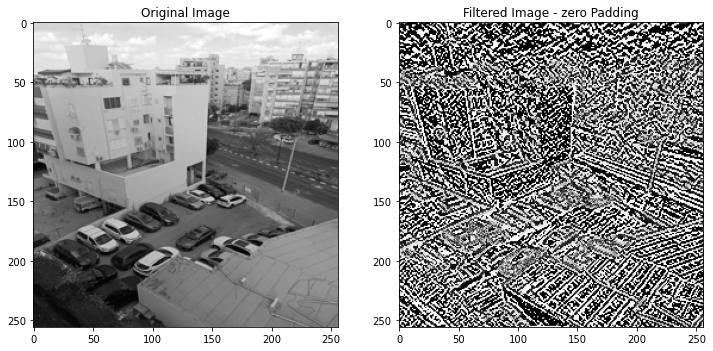

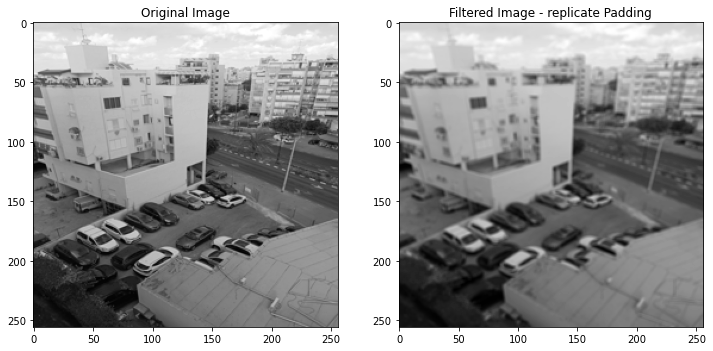

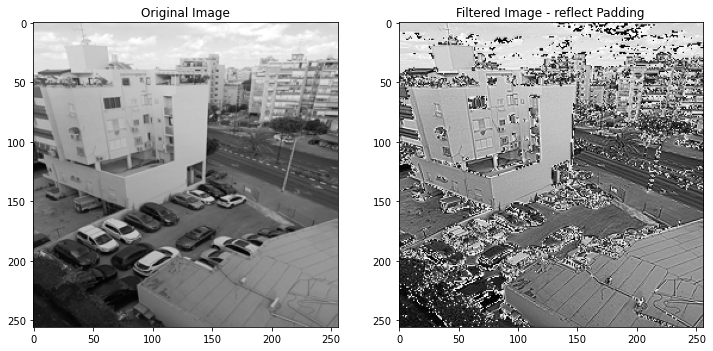

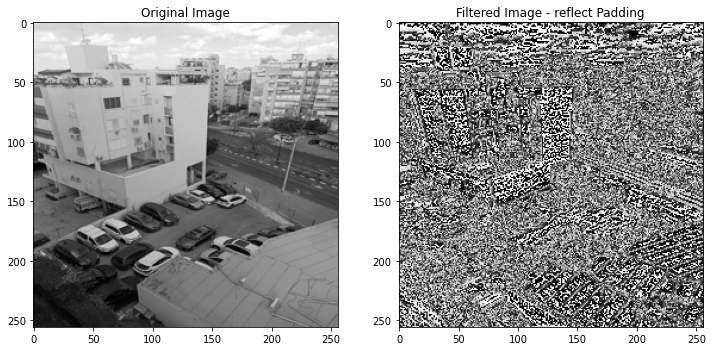

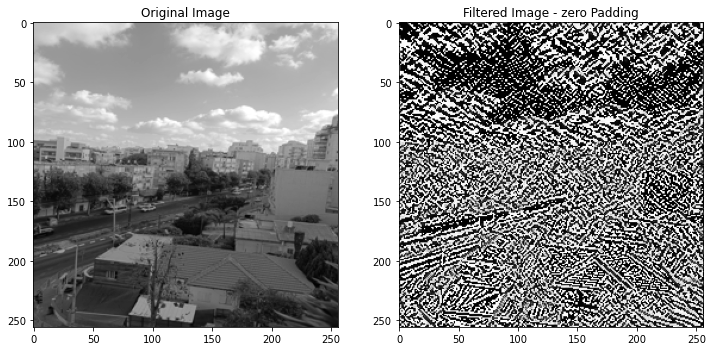

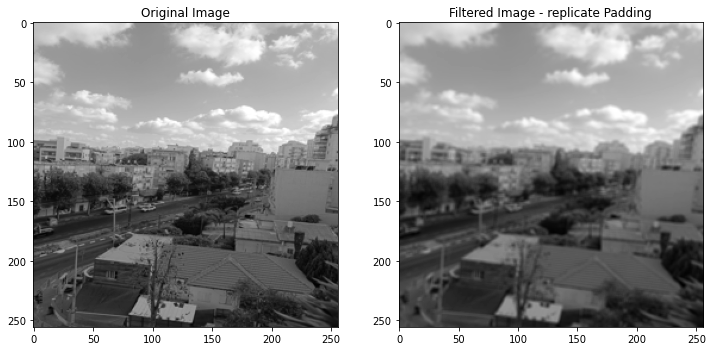

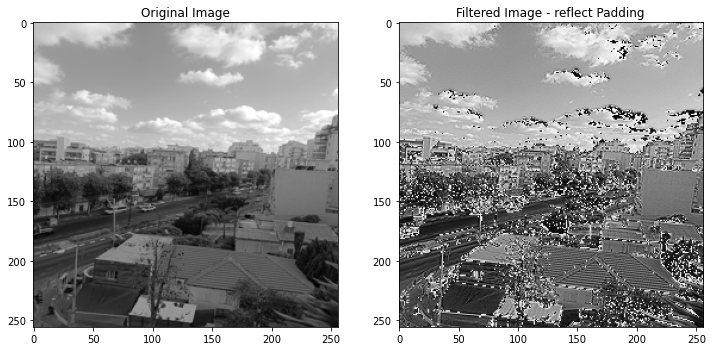

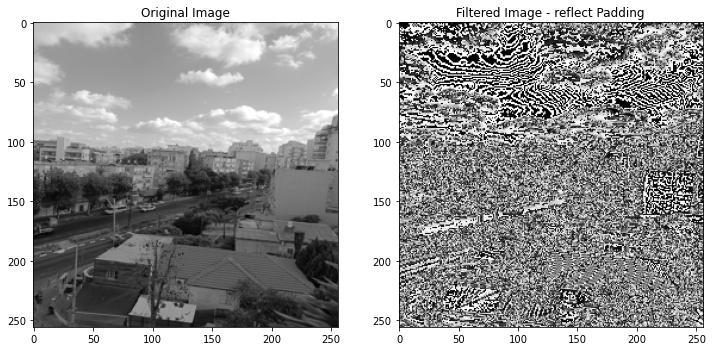

In [9]:
# Load and preprocess the image
image_path = 'C:/Users/בר/Desktop/image3.jpg'
image_array = load_and_preprocess_image(image_path)

# Apply and show filters with different padding options
apply_and_show_filter(image_array, edge_filter, pad_type='zero')
apply_and_show_filter(image_array, blur_filter, pad_type='replicate')
apply_and_show_filter(image_array, sharpen_filter, pad_type='reflect')
apply_and_show_filter(image_array, log_filter, pad_type='reflect')

# Load and preprocess the image
image_path = 'C:/Users/בר/Desktop/image2.jpg'
image_array = load_and_preprocess_image(image_path)

# Apply and show filters with different padding options
apply_and_show_filter(image_array, edge_filter, pad_type='zero')
apply_and_show_filter(image_array, blur_filter, pad_type='replicate')
apply_and_show_filter(image_array, sharpen_filter, pad_type='reflect')
apply_and_show_filter(image_array, log_filter, pad_type='reflect')


In [10]:
def compare_results(original_image, filtered_image):
    difference = np.abs(original_image - filtered_image)
    max_difference = np.max(difference)
    print(f'Max Difference: {max_difference}')
    
    plt.figure(figsize=(6, 6))
    plt.title('Difference Image')
    plt.imshow(difference, cmap='hot')
    plt.colorbar()
    plt.show()


Max Difference: 255


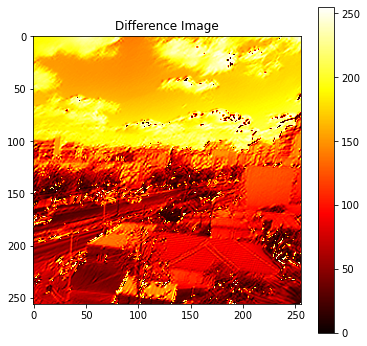

In [11]:
# Example: Compare the results for the edge filter with zero padding
filtered_image = my_imfilter(image_array, edge_filter, pad_type='zero')
compare_results(image_array, filtered_image)
